# ML Bias y Explicabilidad de Modelos con SageMaker Clarify.

Amazon SageMaker Clarify proporciona a los desarrolladores de machine learning (ML) herramientas especialmente diseñadas para obtener una mayor comprensión de sus datos y modelos de entrenamiento de ML. Amazon Clarify detecta y mide el sesgo potencial mediante una variedad de métricas para que puedan abordar el sesgo potencial y explicar las predicciones del modelo.

Tenemos dos Tipos distintos de bias:
- Data bias: desbalance de los diferentes grupos o categorías,
- Model bias: introducido por el model.

In [2]:
!pip install -q sagemaker-experiments

Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import sagemaker
import boto3

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()
prefix = 'module_4/part_10'

In [15]:
from datetime import datetime, timedelta, timezone
import json, os, re, uuid
from time import sleep, gmtime, strftime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from botocore.exceptions import ClientError

from sagemaker import image_uris
from sagemaker.s3 import S3Uploader, S3Downloader
from sagemaker.inputs import TrainingInput

from sagemaker import clarify

### Preparación de los datos
- Usaremos la base de distrubución de salarios de University of California Irvine (UCI).
- Queremos predecir si una persona gana más de $50,000 ($50K)

Features:
1. **Age**: continuous.
1. **Workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
1. **Fnlwgt**: continuous (the number of people the census takers believe that observation represents).
1. **Education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
1. **Education-num**: continuous.
1. **Marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
1. **Occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
1. **Relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
1. **Ethnic group**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
1. **Sex**: Female, Male.
    * **Note**: this data is extracted from the 1994 Census and enforces a binary option on Sex
1. **Capital-gain**: continuous.
1. **Capital-loss**: continuous.
1. **Hours-per-week**: continuous.
1. **Native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Target:  
15. **Target**: <=50,000, >$50,000.

In [5]:
orig_columns=[
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
    'hours-per-week', 'native-country', 'target'
]

df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
    names=orig_columns, sep=r'\s*,\s*', na_values='?', engine='python'

)

df_valtest = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', 
    names=orig_columns, skiprows=1, sep=r'\s*,\s*', na_values='?', engine='python'
)

df.drop(columns='education', inplace=True)
df_valtest.drop(columns='education', inplace=True)
df_valtest['target'] = df_valtest['target'].replace(to_replace=['<=50K.', '>50K.'], 
                                                    value=['<=50K', '>50K'])
# move the target column to first for XGBoost
new_columns=df.columns.tolist()
new_columns=[new_columns[-1]]+new_columns[:-1]
df=df[new_columns]
df_valtest=df_valtest[new_columns]

In [6]:
df.head()

,target,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,<=50K,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,<=50K,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,<=50K,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,<=50K,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,<=50K,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [7]:
# Categorical features to ordinal
# Ej:
# - sex: Male (1), Female (0)
# - target: >50K (1), <=50K (0)

from sklearn import preprocessing

categorical_columns = df.select_dtypes(include='object').columns

encoder = preprocessing.OrdinalEncoder(dtype=int)
df[categorical_columns] = encoder.fit_transform(df[categorical_columns].fillna('NaN'))
df_valtest[categorical_columns] = encoder.transform(df_valtest[categorical_columns].fillna('NaN'))

In [9]:
encoder.categories_

[array(['<=50K', '>50K'], dtype=object),
 array(['Federal-gov', 'Local-gov', 'NaN', 'Never-worked', 'Private',
        'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'],
       dtype=object),
 array(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
       dtype=object),
 array(['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'NaN',
        'Other-service', 'Priv-house-serv', 'Prof-specialty',
        'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'],
       dtype=object),
 array(['Husband', 'Not-in-family', 'Other-relative', 'Own-child',
        'Unmarried', 'Wife'], dtype=object),
 array(['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other',
        'White'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba',
        'D

In [8]:
df

,target,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0,39,7,77516,13,4,0,1,4,1,2174,0,40,39
1,0,50,6,83311,13,2,3,0,4,1,0,0,13,39
2,0,38,4,215646,9,0,5,1,4,1,0,0,40,39
3,0,53,4,234721,7,2,5,0,2,1,0,0,40,39
4,0,28,4,338409,13,2,10,5,2,0,0,0,40,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,27,4,257302,12,2,13,5,4,0,0,0,38,39
32557,1,40,4,154374,9,2,6,0,4,1,0,0,40,39
32558,0,58,4,151910,9,6,0,4,4,0,0,0,40,39
32559,0,22,4,201490,9,4,0,3,4,1,0,0,20,39


#### Division val -test

In [16]:
from sklearn.model_selection import train_test_split

df_val, df_test = train_test_split(
    df_valtest, test_size=0.9, random_state=42, 
    shuffle=True, stratify=df_valtest['target']
)

In [17]:
df.shape, df_valtest.shape, df_val.shape, df_test.shape

((32561, 14), (16281, 14), (1628, 14), (14653, 14))

Text(0.5, 0, 'Sex (0: Female, 1: Male)')

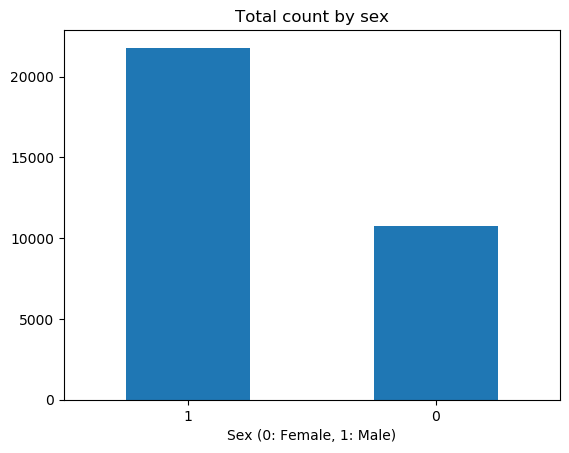

In [18]:
df['sex'].value_counts(sort=False).plot(kind='bar', title='Total count by sex', rot=0)
plt.xlabel('Sex (0: Female, 1: Male)')

Text(0.5, 0, 'target (0: <=50K, 1: >50K)')

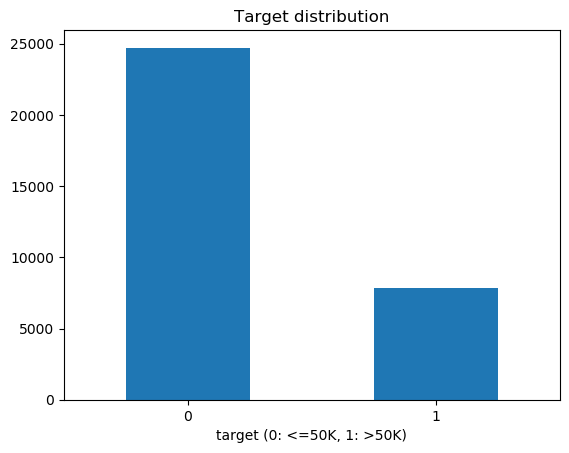

In [19]:
df['target'].value_counts(sort=False).plot(kind='bar', title='Target distribution', rot=0)
plt.xlabel('target (0: <=50K, 1: >50K)')

Text(0.5, 0, 'Sex (0: Female, 1: Male)')

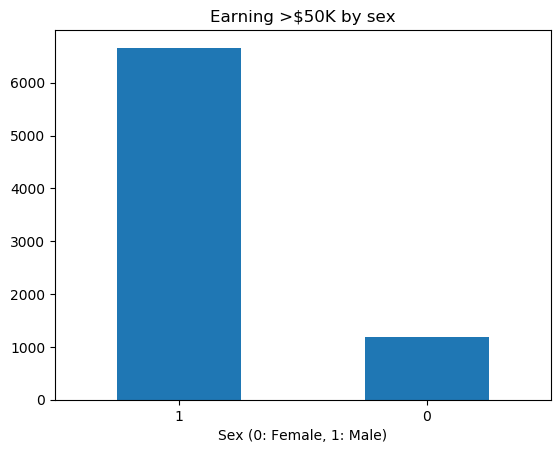

In [20]:
df[df['target']==1]['sex'].value_counts(sort=False).plot(
            kind='bar', title='Earning >$50K by sex', rot=0)
plt.xlabel('Sex (0: Female, 1: Male)')

In [21]:
os.makedirs('data/adult', exist_ok=True)
df.to_csv('data/adult/adult-data-train.csv', index=False, header=False)
df_val.to_csv('data/adult/adult-data-val.csv', index=False, header=False)

train_s3_uri = S3Uploader.upload('data/adult/adult-data-train.csv', f's3://{bucket}/{prefix}/adult-data')
val_s3_uri = S3Uploader.upload('data/adult/adult-data-val.csv', f's3://{bucket}/{prefix}/adult-data')

### Pretraining bias

In [23]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type='ml.m5.xlarge', 
    sagemaker_session=sess
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [24]:
experiment_name = 'adult-income-clarify'

try:
    experiment = Experiment.create(
        experiment_name=experiment_name, 
        description='Analyzing ML bias in adult income dataset using SageMaker Clarify.')
except ClientError as e:
    print(f'{experiment_name} experiment already exists! Reusing the existing experiment.')

In [25]:
# Creating a new trial for the experiment
exp_datetime_1 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())

exp_trial_1 = Trial.create(experiment_name=experiment_name, 
                           trial_name=exp_datetime_1)

experiment_config={
    'ExperimentName': experiment_name,
    'TrialName': exp_trial_1.trial_name,
    'TrialComponentDisplayName': 'Pretraining-BiasAnalysis'
}

In [26]:
pretraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_1.trial_name}/clarify-pretraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_s3_uri,
    s3_output_path=pretraining_bias_report_output_path,
    label='target',
    headers=df.columns.tolist(),
    dataset_type='text/csv',
)

In [27]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1],  # study the positive class
    facet_name=['sex', 'race'],  # features to analyce
    facet_values_or_threshold=[[0], None] # Compute the metrics when sex=0 and race all
)

In [28]:
jobname = f'adult-clarify-pretraining-bias-{exp_datetime_1}'

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    methods='all',
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['target', 'age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'label': 'target', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'sex', 'value_or_threshold': [0]}, {'name_or_index': 'race'}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}}}
INFO:sagemaker:Creating processing-job with name adult-clarify-pretraining-bias-2022-12-14-14-41-27



Job Name:  adult-clarify-pretraining-bias-2022-12-14-14-41-27
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-data/adult-data-train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-income-clarify-2022-12-14-14-41-27/clarify-pretraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-income-clarify-2022-12-14-14-41-27/clarify-pretraining-b

- Vemos los resultados en la interfaz de experimentos de sagemaker studio.

###  Solución bias: matching

In [35]:
df.groupby(
    ['sex', 'target'], 
    group_keys=False).count()

age  workclass  fnlwgt  education-num  marital-status  \
sex target                                                            
0   0        9592       9592    9592           9592            9592   
    1        1179       1179    1179           1179            1179   
1   0       15128      15128   15128          15128           15128   
    1        6662       6662    6662           6662            6662   

            occupation  relationship   race  capital-gain  capital-loss  \
sex target                                                                
0   0             9592          9592   9592          9592          9592   
    1             1179          1179   1179          1179          1179   
1   0            15128         15128  15128         15128         15128   
    1             6662          6662   6662          6662          6662   

            hours-per-week  native-country  
sex target                                  
0   0                 9592            9592  
    1                 1179            1179  
1   0                15128           15128  
    1                 6662            6662

In [37]:
max_female_sample=df.groupby(
    ['sex', 'target'], 
    group_keys=False).count().loc[(0, 1)]['age']

In [38]:
df_sampled = df.groupby(['sex', 'target'], 
                        group_keys=False).apply(lambda x: x.sample(max_female_sample))

In [42]:
df_sampled.shape

(4716, 14)

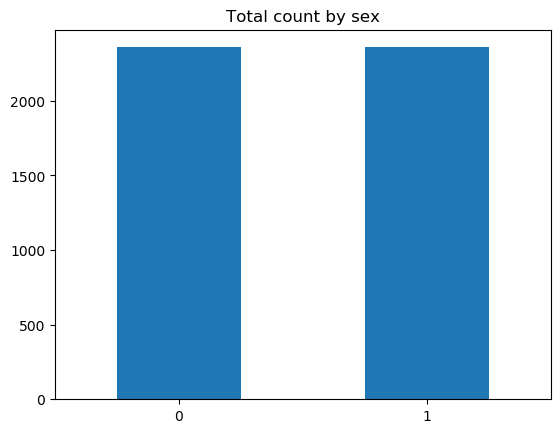

In [43]:
df_sampled['sex'].value_counts().sort_values().plot(kind='bar', 
                                                    title='Total count by sex', 
                                                    rot=0)

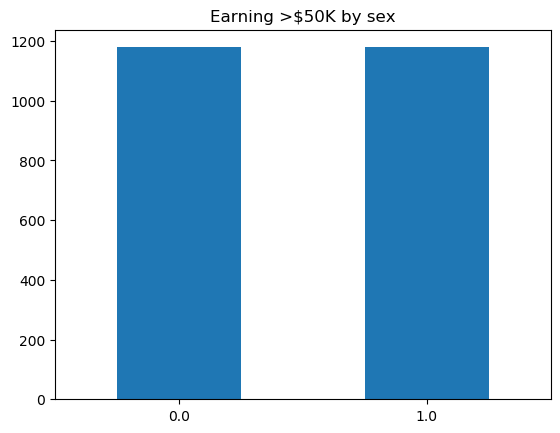

In [44]:
df_sampled['sex'].where(df_sampled['target'] == 1).value_counts().sort_values().plot(
    kind='bar', title='Earning >$50K by sex', rot=0)

In [47]:
df_sampled.to_csv('data/adult/adult-data-train-sampled.csv', index=False, header=False)
train_sampled_s3_uri = S3Uploader.upload('data/adult/adult-data-train-sampled.csv', 
                                      f's3://{bucket}/{prefix}/adult-data')

### Rerun pre-training bias


In [48]:
exp_datetime_2 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())

# Creating a new trial as we are working on a new dataset
exp_trial_2 = Trial.create(
    experiment_name=experiment_name, 
    trial_name=exp_datetime_2
)

experiment_config={
    'ExperimentName': experiment_name,
    'TrialName': exp_trial_2.trial_name,
    'TrialComponentDisplayName': 'Pretraining-BiasAnalysis'
}

pretraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-pretraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=pretraining_bias_report_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv'
)

bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], 
    facet_name=['sex', 'race'], 
    facet_values_or_threshold=[[0], None]
)

jobname = f'adult-sampled-clarify-pretraining-bias-{exp_datetime_2}'

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    methods='all',
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['target', 'age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'label': 'target', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'sex', 'value_or_threshold': [0]}, {'name_or_index': 'race'}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}}}
INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-pretraining-bias-2022-12-14-15-00-23



Job Name:  adult-sampled-clarify-pretraining-bias-2022-12-14-15-00-23
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-income-clarify-2022-12-14-15-00-23/clarify-pretraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-income-clarify-2022-12-14-15-00-23/clari

## Training a ML model using XGBoost

In [ ]:
exp_datetime_3 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
jobname = f'adult-xgb-{exp_datetime_3}'

experiment_config={
    'ExperimentName': experiment_name,
    'TrialName': exp_trial_2.trial_name,
    'TrialComponentDisplayName': 'Training'
}

image = image_uris.retrieve(region=region, framework='xgboost', version='1.3-1')

train_s3_output = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/training'

xgb = sagemaker.estimator.Estimator(
    image,
    role,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    output_path=train_s3_output,
    enable_sagemaker_metrics=True,
    sagemaker_session=sess
)
xgb.set_hyperparameters(
    objective='binary:logistic',
    eval_metric='error',
    num_round=50
)

train_input = sagemaker.inputs.TrainingInput(s3_data=train_sampled_s3_uri,  content_type='csv')
val_input = sagemaker.inputs.TrainingInput(s3_data=val_s3_uri, content_type='csv')
data_channels={'train': train_input, 'validation': val_input}

xgb.fit(
    inputs=data_channels, 
    job_name=jobname, 
    experiment_config=experiment_config, 
    wait=True
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: adult-xgb-2022-12-14-15-00-28


2022-12-14 15:00:28 Starting - Starting the training job...
2022-12-14 15:00:51 Starting - Preparing the instances for trainingProfilerReport-1671030028: InProgress
.....

In [50]:
model_name = f'adult-xgb-model-{exp_datetime_3}'
model = xgb.create_model(name=model_name)

container_def = model.prepare_container_def()
sess.create_model(model_name, role, container_def)

INFO:sagemaker:Creating model with name: adult-xgb-model-2022-12-14-15-00-28


'adult-xgb-model-2022-12-14-15-00-28'

## Post-training bias

In [51]:
experiment_config={
    'ExperimentName': experiment_name,
    'TrialName': exp_trial_2.trial_name,
    'TrialComponentDisplayName': 'Posttraining-BiasAnalysis'
}

posttraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-posttraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=posttraining_bias_report_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv'
)

bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], 
    facet_name=['sex', 'race'], 
    facet_values_or_threshold=[[0], None]
)

In [52]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    accept_type='text/csv',
    content_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

In [53]:
exp_datetime_4 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
jobname = f'adult-sampled-clarify-posttraining-bias-{exp_datetime_4}'

clarify_processor.run_post_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    methods='all',    
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['target', 'age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'label': 'target', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'sex', 'value_or_threshold': [0]}, {'name_or_index': 'race'}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'post_training_bias': {'methods': 'all'}}, 'predictor': {'model_name': 'adult-xgb-model-2022-12-14-15-00-28', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'content_type': 'text/csv'}, 'probability_threshold': 0.5}
INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-posttraining-bias-2022-12-14-19-55-05



Job Name:  adult-sampled-clarify-posttraining-bias-2022-12-14-19-55-05
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-income-clarify-2022-12-14-15-00-23/clarify-posttraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-income-clarify-2022-12-14-15-00-23/cla

## Explicabilidad del modelo con valores SHAP

In [54]:
experiment_config={
    'ExperimentName': experiment_name,
    'TrialName': exp_trial_2.trial_name,
    'TrialComponentDisplayName': 'Posttraining-SHAP'
}

explainability_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-explainability'

explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=explainability_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv'
)

model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    accept_type='text/csv',
    content_type='text/csv'
)

baseline = df_sampled.query('target == 1').mode().iloc[0, 1:].astype(int).tolist()
shap_config = clarify.SHAPConfig(
    baseline=[baseline],
    num_samples=15,
    agg_method='mean_abs'
)

In [55]:
exp_datetime_5 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
jobname = f'adult-sampled-clarify-posttraining-shap-{exp_datetime_5}'

clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
    job_name=jobname,
    experiment_config=experiment_config
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['target', 'age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'label': 'target', 'predictor': {'model_name': 'adult-xgb-model-2022-12-14-15-00-28', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'content_type': 'text/csv'}, 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'shap': {'use_logit': False, 'save_local_shap_values': True, 'baseline': [[39, 4, 101345, 13, 2, 10, 0, 4, 0, 0, 0, 40, 39]], 'num_samples': 15, 'agg_method': 'mean_abs'}}}
INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-posttraining-shap-2022-12-14-19-55-43



Job Name:  adult-sampled-clarify-posttraining-shap-2022-12-14-19-55-43
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-income-clarify-2022-12-14-15-00-23/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-eu-west-1-467432373215/module_4/part_10/adult-income-clarify-2022-12-14-15-00-23/clarif

Example number: 500
with model prediction: <=50K

Feature values: 
       target  age  workclass  fnlwgt  education-num  marital-status  \
17552       0   23          4  209034              9               2   

       occupation  relationship  race  sex  capital-gain  capital-loss  \
17552           6             5     4    0          3942             0   

       hours-per-week  native-country  
17552              40              39  


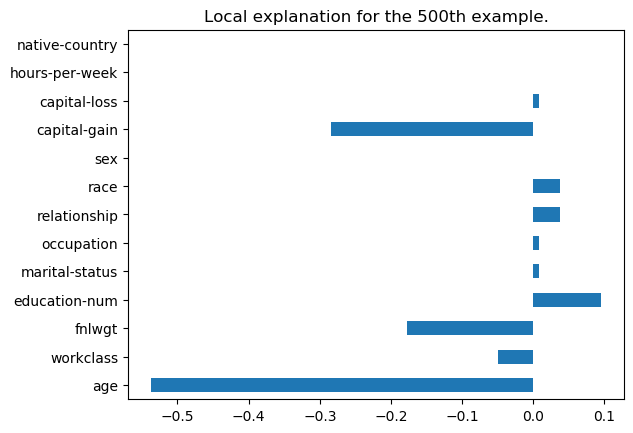

In [56]:
S3Downloader.download(f'{explainability_output_path}/explanations_shap/out.csv', 
                      './',
                      sagemaker_session=sess)
local_explanations_out = pd.read_csv('out.csv')
feature_names = [str.replace(c, '_label0', '') 
                 for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 500
sample_prediction='>50K' if sum(local_explanations_out.iloc[selected_example]) > 0 else '<=50K'
print(f'Example number: {selected_example}')
print(f'with model prediction: {sample_prediction}')
print()
print(f'Feature values: \n{df_sampled.iloc[selected_example].to_frame().T}')

local_explanations_out.iloc[selected_example].plot(
    kind='barh', 
    title=f'Local explanation for the {selected_example}th example.', 
    rot=0)

### Clean Up

In [59]:
## Eliminamos el modelo
sess.delete_model(model_name)

INFO:sagemaker:Deleting model with name: adult-xgb-model-2022-12-14-15-00-28


ClientError: An error occurred (ValidationException) when calling the DeleteModel operation: Could not find model "arn:aws:sagemaker:eu-west-1:467432373215:model/adult-xgb-model-2022-12-14-15-00-28".